In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split
import os

Get the input and label files from CSVs

In [12]:
input_files = sorted(
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_input.csv') + 
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_input.csv') + 
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_input.csv')
    )
label_files = sorted(
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS.csv') +
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_BORIS.csv') +
    glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_BORIS.csv')
    )

In [13]:
def get_train_test_splitted_data(label_files, input_files, global_mean, global_std, test_size=0.2, random_state=42):
    # Initialize lists to hold all sequences
    all_x_sequences = []
    all_y_sequences = []

    # Process each pair of input and label files
    for input_file, label_file in zip(input_files, label_files):
        # Load data
        input_df = pd.read_csv(input_file)
        label_df = pd.read_csv(label_file)

        # Prepare features and labels
        features = (input_df.values - global_mean) / global_std
        labels = label_df.values / 100

        # Ensure alignment of frames
        if features.shape[0] != labels.shape[0]:
            print(f"Mismatch in frames: {input_file}, {label_file}")
            continue

        # Sample sequences
        x_sequences, y_sequences = create_sequences(features, labels, SEQUENCE_LENGTH, STRIDE)

        # Append to global lists
        all_x_sequences.append(x_sequences)
        all_y_sequences.append(y_sequences)

    # Concatenate all sequences from all files
    all_x_sequences = np.concatenate(all_x_sequences, axis=0)
    all_y_sequences = np.concatenate(all_y_sequences, axis=0)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        all_x_sequences, all_y_sequences, test_size=test_size, random_state=random_state
    )

    # Convert to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Shuffle, batch, and prefetch
    train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    return train_dataset, test_dataset

In [14]:
# Constants
SEQUENCE_LENGTH = 10
STRIDE = 5
BATCH_SIZE = 32

# Helper function to create random sequences
def create_sequences(features, labels, sequence_length, stride):
    x_sequences, y_sequences = [], []
    for i in range(0, len(features) - sequence_length + 1, stride):
        x_sequences.append(features[i:i + sequence_length])
        y_sequences.append(labels[i:i + sequence_length])
    return np.array(x_sequences), np.array(y_sequences)

# Initialize lists to hold all sequences
all_x_sequences = []
all_y_sequences = []
all_features = []

sources = ["GUT", "ITU-YU", "MAAP"]
base_path = "//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/"
input_files, label_files = [], []

for source in sources:
    input_files.extend(glob.glob(os.path.join(base_path, source, '*_input.csv')))
    label_files.extend(glob.glob(os.path.join(base_path, source, '*_BORIS.csv')))

input_files.sort()
label_files.sort()


for input_file in input_files:
    input_df = pd.read_csv(input_file)
    all_features.append(input_df.values)

# Concatenate all features from all files to compute global mean and std
all_features = np.concatenate(all_features, axis=0)
global_mean = all_features.mean(axis=0)
global_std = all_features.std(axis=0)

# Ensure no division by zero
global_std[global_std == 0] = 1

GUT_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_input.csv'))
ITU_YU_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_input.csv'))
MAAP_path_input = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_input.csv'))

GUT_path_label = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/GUT/*_BORIS.csv'))
ITU_YU_path_label = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/ITU-YU/*_BORIS.csv'))
MAAP_path_label = sorted(glob.glob('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/MAAP/*_BORIS.csv'))

GUT_train, GUT_test = get_train_test_splitted_data(GUT_path_label, GUT_path_input, global_mean, global_std, test_size=0.3)
ITU_YU_train, ITU_YU_test = get_train_test_splitted_data(ITU_YU_path_label, ITU_YU_path_input, global_mean, global_std, test_size=0.3)
MAAP_train, MAAP_test = get_train_test_splitted_data(MAAP_path_label, MAAP_path_input, global_mean, global_std, test_size=0.3)

dataset = GUT_train.concatenate(ITU_YU_train).concatenate(MAAP_train)

KeyboardInterrupt: 

In [49]:
path = r'Z:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'
tf.data.experimental.save(dataset ,os.path.join(path, 'train_dataset'))
tf.data.experimental.save(GUT_train, os.path.join(path, 'GUT_train'))
tf.data.experimental.save(GUT_test, os.path.join(path, 'GUT_test'))
tf.data.experimental.save(ITU_YU_train, os.path.join(path, 'ITU_YU_train'))
tf.data.experimental.save(ITU_YU_test, os.path.join(path, 'ITU_YU_test'))
tf.data.experimental.save(MAAP_train, os.path.join(path, 'MAAP_train'))
tf.data.experimental.save(MAAP_test, os.path.join(path, 'MAAP_test'))

In [19]:
for x_batch, y_batch in dataset.take(30):
    print(f'Feature batch shape: {x_batch.shape}')
    print(f'Label batch shape: {y_batch.shape}')

Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature batch shape: (32, 10, 515)
Label batch shape: (32, 10, 6)
Feature ba

In [51]:
INPUT_DIM = 515  # Number of features per frame (e.g., biosignals + embeddings)
OUTPUT_DIM = 6 

In [52]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(SEQUENCE_LENGTH, INPUT_DIM)),    # Input shape: (sequence_length, features)
    tf.keras.layers.LSTM(64, return_sequences=True),              # LSTM layer to capture temporal patterns
    tf.keras.layers.Dense(32, activation='relu'),                 # Dense layer to reduce dimensionality
    tf.keras.layers.Dense(OUTPUT_DIM, activation='sigmoid')       # Output layer with sigmoid for continuous values between 0 and 1
])

In [53]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [54]:
history = model.fit(dataset, epochs=50)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0922 - mae: 0.2263
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0359 - mae: 0.0771
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0339 - mae: 0.0707
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0324 - mae: 0.0672
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0314 - mae: 0.0639
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0301 - mae: 0.0625
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0291 - mae: 0.0615
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0284 - mae: 0.0590
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0279 - mae: 0.0579
Epoch 10/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0272 - mae: 0.0560
Epoch 11/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0265 - mae: 0.0537
Epoch 12/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0261 - mae: 0.0530
Epoch 13/50
225/225 ━━━━━

In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,276 (1.73 MB)

 Trainable params: 150,758 (588.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 301,518 (1.15 MB)

In [ ]:
path = r'Z:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'
train = tf.data.experimental.save(dataset ,os.path.join(path, 'train_dataset'))
tf.data.experimental.save(GUT_train, os.path.join(path, 'GUT_train'))
tf.data.experimental.save(GUT_test, os.path.join(path, 'GUT_test'))
tf.data.experimental.save(ITU_YU_train, os.path.join(path, 'ITU_YU_train'))
tf.data.experimental.save(ITU_YU_test, os.path.join(path, 'ITU_YU_test'))
tf.data.experimental.save(MAAP_train, os.path.join(path, 'MAAP_train'))
tf.data.experimental.save(MAAP_test, os.path.join(path, 'MAAP_test'))

In [72]:
# Evaluate the model
loss, acc = model.evaluate(MAAP_test, verbose=2)
print("Untrained model, coherence: {:5.2f}%".format(100 * (1-acc)))

72/72 - 0s - 3ms/step - loss: 0.0355 - mae: 0.0604
Untrained model, accuracy: 93.96%


In [66]:
model.save(os.path.join(path, 'saved_model/model.keras'))

In [9]:
new_model = tf.keras.models.load_model('//153.19.52.107/emboa/IO3-sessions/NEW STRUCTURE/de-earlyfusionthesis/Datasets/saved_model/model.keras')

In [10]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10, 6)          │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,276 (1.73 MB)

 Trainable params: 150,758 (588.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 301,518 (1.15 MB)

In [77]:
path = r'S:\IO3-sessions\NEW STRUCTURE\de-earlyfusionthesis\Datasets'

train_dataset_path = os.path.abspath(os.path.join(path, 'train_dataset'))
GUT_test_path = os.path.join(path, 'GUT_test').replace("\\", "/")
ITU_YU_test_path = os.path.join(path, 'ITU_YU_test').replace("\\", "/")
MAAP_test_path = os.path.join(path, 'MAAP_test').replace("\\", "/")

# Load datasets
train = tf.data.Dataset.load(train_dataset_path)
GUT_test = tf.data.experimental.load(GUT_test_path)
ITU_YU_test = tf.data.experimental.load(ITU_YU_test_path)
MAAP_test = tf.data.experimental.load(MAAP_test_path)

In [70]:
import matplotlib.pyplot as plt

# After training, 'history' holds the metrics for each epoch
# Plot MAE from the training history

# Access 'mae' values for each epoch
mae = history.history['mae']  # MAE for training data
# If you had validation data, access validation MAE as well
# val_mae = history.history['val_mae']

# Plot training MAE
plt.plot(mae, label='Training MAE')
# Uncomment below if you have validation data to compare
# plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model MAE over Epochs')
plt.legend()
plt.grid()
plt.show()


NameError: name 'history' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


C:\Users\oskik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\oskik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\oskik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\oskik\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\oskik\AppData\Local\Programs\Python\Python3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

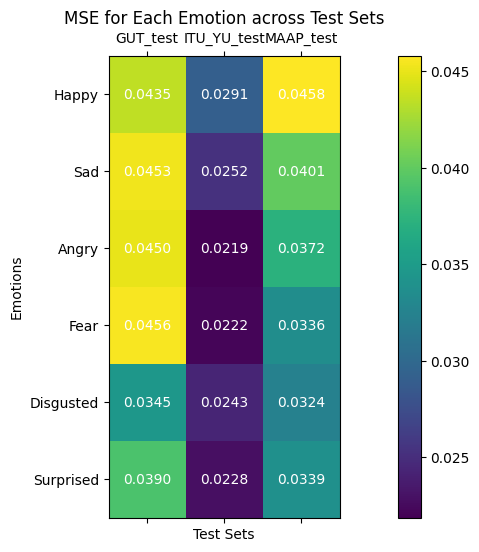

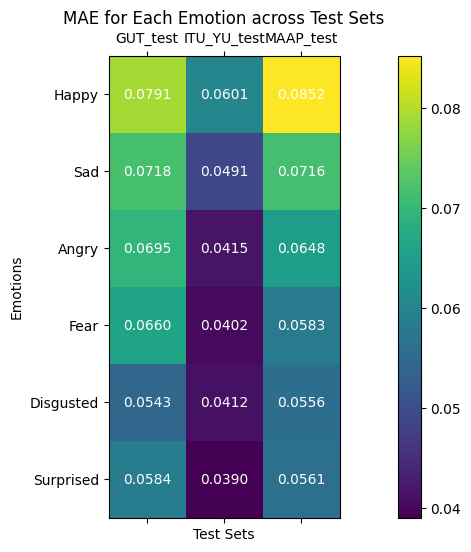

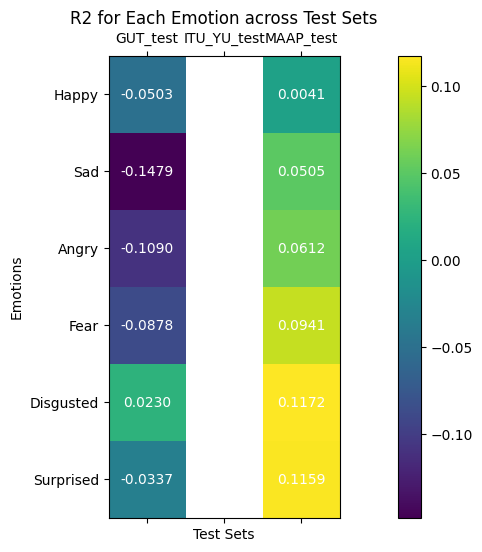

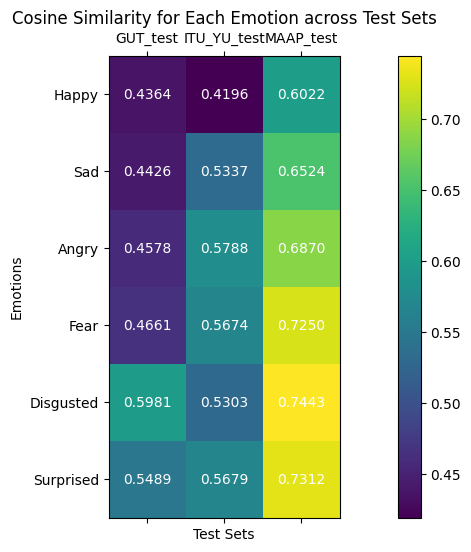

In [82]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity

# Define your custom R^2 metric for TensorFlow
def r_squared(y_true, y_pred):
    ss_total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    ss_residual = tf.reduce_sum(tf.square(y_true - y_pred))
    return 1 - (ss_residual / ss_total)

# Function to compute metrics for each emotion separately
def compute_metrics(y_true, y_pred, emotions):
    # Initialize dictionary to store metrics for each emotion
    metrics = {}
    
    for i, emotion in enumerate(emotions):
        true_values = y_true[:, i]  # Actual values for this emotion
        predicted_values = y_pred[:, i]  # Predicted values for this emotion
        
        # Mean Squared Error (MSE)
        mse = mean_squared_error(true_values, predicted_values)
        
        # Mean Absolute Error (MAE)
        mae = mean_absolute_error(true_values, predicted_values)
        
        # R-Squared (R²)
        r2 = r2_score(true_values, predicted_values)
        
        # Cosine Similarity (if you want to track how well the proportion matches)
        cosine_sim = cosine_similarity(true_values.reshape(1, -1), predicted_values.reshape(1, -1))[0][0]
        
        # Store metrics for this emotion
        metrics[emotion] = {
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'Cosine Similarity': cosine_sim
        }
    
    return metrics

# Define the emotion labels (you can modify as needed)
emotions = ["Happy", "Sad", "Angry", "Fear", "Disgusted", "Surprised"]

# Function to evaluate the model and return metrics for each test set
def evaluate_model_on_test_set(model, test_set, emotions):
    # Initialize dictionary to store metrics for this test set
    metrics_dict = {
        'MSE': {emotion: [] for emotion in emotions},
        'MAE': {emotion: [] for emotion in emotions},
        'R2': {emotion: [] for emotion in emotions},
        'Cosine Similarity': {emotion: [] for emotion in emotions}
    }
    
    # Loop over the test set batches
    for x_batch, y_batch in test_set:
        # Get predictions from the model
        y_pred = model.predict(x_batch)
        
        # Compute metrics for each emotion
        metrics = compute_metrics(y_batch.numpy(), y_pred, emotions)
        
        # Store metrics for this batch
        for metric in ['MSE', 'MAE', 'R2', 'Cosine Similarity']:
            for emotion in emotions:
                metrics_dict[metric][emotion].append(metrics[emotion][metric])
    
    # Return the metrics dictionary with lists of values for each emotion and metric
    return metrics_dict

# Function to plot metrics in grid format
def plot_metrics_grid(metrics_dict, emotions, test_sets, metric_name):
    """
    Display the metrics in a 6x3 grid where each row represents an emotion
    and each column represents a test set.
    """
    # Prepare data for plotting
    metric_values = np.zeros((len(emotions), len(test_sets)))
    
    # Iterate through each emotion and test set
    for i, emotion in enumerate(emotions):
        for j, test_set_name in enumerate(test_sets):
            # Compute the mean of the metrics for this emotion and test set
            metric_values[i, j] = np.mean(metrics_dict[test_set_name][metric_name][emotion])

    # Create the plot
    fig, ax = plt.subplots(figsize=(15,6))
    cax = ax.matshow(metric_values, cmap='viridis')

    # Set axis labels
    ax.set_xticks(np.arange(len(test_sets)))
    ax.set_xticklabels(test_sets)
    ax.set_yticks(np.arange(len(emotions)))
    ax.set_yticklabels(emotions)

    # Add color bar
    fig.colorbar(cax)

    # Label each cell with the numeric value
    for i in range(len(emotions)):
        for j in range(len(test_sets)):
            ax.text(j, i, f'{metric_values[i, j]:.4f}', ha='center', va='center', color='white')

    # Set title
    ax.set_title(f'{metric_name} for Each Emotion across Test Sets')

    plt.xlabel('Test Sets')
    plt.ylabel('Emotions')
    plt.show()

# Example for evaluating the model on each test set


# List of test sets (as keys to access the metrics)
test_sets = ['GUT_test', 'ITU_YU_test', 'MAAP_test']

# Initialize dictionary to store metrics for each test set
all_metrics_dict = {
    'GUT_test': {'MSE': {emotion: [] for emotion in emotions}, 'MAE': {emotion: [] for emotion in emotions}, 'R2': {emotion: [] for emotion in emotions}, 'Cosine Similarity': {emotion: [] for emotion in emotions}},
    'ITU_YU_test': {'MSE': {emotion: [] for emotion in emotions}, 'MAE': {emotion: [] for emotion in emotions}, 'R2': {emotion: [] for emotion in emotions}, 'Cosine Similarity': {emotion: [] for emotion in emotions}},
    'MAAP_test': {'MSE': {emotion: [] for emotion in emotions}, 'MAE': {emotion: [] for emotion in emotions}, 'R2': {emotion: [] for emotion in emotions}, 'Cosine Similarity': {emotion: [] for emotion in emotions}},
}

# Compute metrics for each test set and store them
for test_set_name, test_data in zip(test_sets, [GUT_test, ITU_YU_test, MAAP_test]):
    test_metrics = evaluate_model_on_test_set(new_model, test_data, emotions)
    
    # Store metrics for this test set
    for metric in ['MSE', 'MAE', 'R2', 'Cosine Similarity']:
        for emotion in emotions:
            all_metrics_dict[test_set_name][metric][emotion].extend(test_metrics[metric][emotion])

# Plot the metrics in grid format for each metric
for metric_name in ['MSE', 'MAE', 'R2', 'Cosine Similarity']:
    plot_metrics_grid(all_metrics_dict, emotions, test_sets, metric_name)
